In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
import sys

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize

from math import log10
import torchvision.utils as utils
from utils import preprocess, Lr_Hr_dataset, zip_folder, Cat_dog_dataset, generate_dataset, plot_loss
from SRGANLOSS import GeneratorLoss
from SRGAN import Generator, Discriminator
import pandas as pd
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Folder 'training_results/fake_data' successfully zipped to 'training_results/fake_data.zip'


In [44]:
cat_and_dog_images_hr, labels = preprocess('C:/STD/Course/AI Application/Applied_AI_midterm_exam/dataset/train.zip')
lr_hr_dataset = Lr_Hr_dataset(cat_and_dog_dataset=cat_and_dog_images_hr, labels=labels, transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 25000/25000 [01:26<00:00, 289.05it/s]


In [45]:
train_dataset, test_dataset = train_test_split(lr_hr_dataset, test_size=0.3, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
            


In [66]:
def train(train_loader, test_loader, num_epochs=150, learning_rate=0.0001):
    netG = Generator(scale_factor=4)
    netD = Discriminator()
    netG.apply(weights_init)
    netD.apply(weights_init)
    generator_criterion = GeneratorLoss()
    if device == 'cuda':
        netG.cuda()
        netD.cuda()
        generator_criterion.cuda()

    optimizerG = optim.Adam(netG.parameters(), lr=learning_rate*3)
    optimizerD = optim.Adam(netD.parameters(), lr=learning_rate/10)
    results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

    for epoch in range(0, num_epochs):
        running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

        netG.train()
        netD.train()

        train_bar = tqdm(train_loader, mininterval=1, leave=True, ncols=100, desc=f"Epoch {epoch+1}/{num_epochs}", file=sys.stdout, disable=False, miniters=1)

        for data, target, _ in train_bar:
            batch_size = data.size(0)
            running_results['batch_sizes'] += batch_size

            # training generator
            real_img = target
            z = data
            if device == 'cuda':
                z = z.float().cuda()
                real_img = real_img.float().cuda()

            fake_img = netG(z)
            fake_out = netD(fake_img).mean()

            optimizerG.zero_grad()
            g_loss = generator_criterion(fake_out, fake_img, real_img)
            g_loss.backward()
            optimizerG.step()

            # training discriminator
            real_out = netD(real_img).mean()
            fake_out = netD(fake_img.detach()).mean()
            d_loss = 1 - real_out + fake_out

            optimizerD.zero_grad()
            d_loss.backward()
            fake_img = netG(z)
            fake_out = netD(fake_img).mean()
            
            optimizerD.step()

            # accumulate losses and scores for the current batch
            running_results['g_loss'] += g_loss.item() * batch_size
            running_results['d_loss'] += d_loss.item() * batch_size
            running_results['d_score'] += real_out.item() * batch_size
            running_results['g_score'] += fake_out.item() * batch_size


            train_bar.set_postfix({
                'Loss_D': running_results['d_loss'] / running_results['batch_sizes'],
                'Loss_G': running_results['g_loss'] / running_results['batch_sizes']
            })

     
        netG.eval()
        valing_results = {'mse': 0, 'psnr': 0, 'batch_sizes': 0}
        with torch.no_grad():
            val_images = []

            val_bar = tqdm(test_loader, mininterval=1, leave=True, ncols=100, desc=f"Validation {epoch+1}/{num_epochs}")
            for val_lr, val_hr, _ in val_bar:
                batch_size = val_lr.size(0)
                valing_results['batch_sizes'] += batch_size
                lr = val_lr
                hr = val_hr
                if device == 'cuda':
                    lr = lr.float().cuda()
                    hr = hr.float().cuda()
                sr = netG(lr)

                batch_mse = ((sr - hr) ** 2).data.mean()
                valing_results['mse'] += batch_mse * batch_size

                valing_results['psnr'] = 10 * log10((hr.max() ** 2) / (valing_results['mse'] / valing_results['batch_sizes']))
                

        results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
        results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
        results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
        results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
        results['psnr'].append(valing_results['psnr'])

  
        out_path = './'
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        data_frame = pd.DataFrame(
            data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
                  'Score_G': results['g_score'], 'PSNR': results['psnr']},
            index=range(1, epoch + 2)) 
        data_frame.to_csv(out_path + 'srf_' + str(4) + '_train_results.csv', index_label='Epoch')

    
    return netG, data_frame

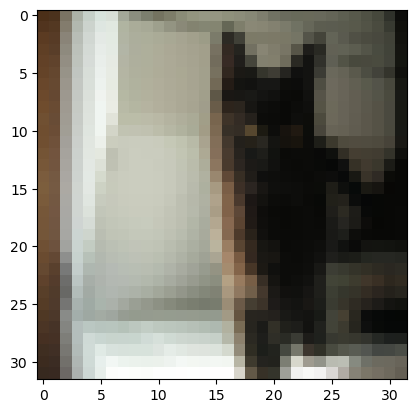

In [59]:
for x, y, z in test_loader:
    plt.imshow(np.transpose(x[0].numpy(), (1, 2, 0)))
    plt.imshow(np.transpose(y[0].numpy(), (1, 2, 0)))
    break

In [68]:
netG, data_frame = train(train_loader, test_loader, num_epochs=150, learning_rate=0.0001)

Epoch 1/150: 100%|████████████████████| 547/547 [00:51<00:00, 10.62it/s, Loss_D=0.63, Loss_G=0.0114]


Validation 1/150: 100%|██████████████████████████████████████████| 235/235 [00:01<00:00, 174.42it/s]


Epoch 2/150: 100%|█████████████████| 547/547 [00:51<00:00, 10.65it/s, Loss_D=0.0872, Loss_G=0.00855]


Validation 2/150: 100%|██████████████████████████████████████████| 235/235 [00:01<00:00, 176.24it/s]


Epoch 3/150: 100%|█████████████████| 547/547 [00:51<00:00, 10.53it/s, Loss_D=0.0187, Loss_G=0.00796]


Validation 3/150: 100%|██████████████████████████████████████████| 235/235 [00:01<00:00, 135.40it/s]


Epoch 4/150: 100%|██████████████████| 547/547 [00:53<00:00, 10.30it/s, Loss_D=0.611, Loss_G=0.00772]


Validation 4/150: 100%|██████████████████████████████████████████| 235/235 [00:01<00:00, 159.16it/s]


Epoch 5/150: 100%|█████████████████| 547/547 [00:51<00:00, 10.63it/s, Loss_D=0.0229, Loss_G=0.00734]


Validation 5/150: 100%|██████████████████████████████████████████| 235/235 [00:01<00:00, 179.88it/s]


Epoch 6/150: 100%|█████████████████| 547/547 [00:50<00:00, 10.79it/s, Loss_D=0.0102, Loss_G=0.00708]


Validation 6/150: 100%|██████████████████████████████████████████| 235/235 [00:01<00:00, 181.26it/s]


Epoch 7/150: 100%|████████████████| 547/547 [00:50<00:00, 10.76it/s, Loss_D=0.00595, Loss_G=0.00688]


Validation 7/150: 100%|██████████████████████████████████████████| 235/235 [00:01<00:00, 180.31it/s]


Epoch 8/150: 100%|████████████████| 547/547 [00:50<00:00, 10.74it/s, Loss_D=0.00393, Loss_G=0.00675]


Validation 8/150: 100%|██████████████████████████████████████████| 235/235 [00:01<00:00, 174.25it/s]


Epoch 9/150: 100%|████████████████| 547/547 [00:50<00:00, 10.74it/s, Loss_D=0.00262, Loss_G=0.00661]


Validation 9/150: 100%|██████████████████████████████████████████| 235/235 [00:01<00:00, 177.59it/s]


Epoch 10/150: 100%|███████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=0.00177, Loss_G=0.00647]


Validation 10/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 178.66it/s]


Epoch 11/150: 100%|███████████████| 547/547 [00:51<00:00, 10.64it/s, Loss_D=0.00115, Loss_G=0.00636]


Validation 11/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 176.03it/s]


Epoch 12/150: 100%|██████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=0.000851, Loss_G=0.00627]


Validation 12/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 175.91it/s]


Epoch 13/150: 100%|██████████████| 547/547 [00:50<00:00, 10.75it/s, Loss_D=0.000544, Loss_G=0.00614]


Validation 13/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 177.74it/s]


Epoch 14/150: 100%|██████████████| 547/547 [00:51<00:00, 10.69it/s, Loss_D=0.000431, Loss_G=0.00604]


Validation 14/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 169.91it/s]


Epoch 15/150: 100%|██████████████| 547/547 [00:50<00:00, 10.73it/s, Loss_D=0.000275, Loss_G=0.00601]


Validation 15/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 181.66it/s]


Epoch 16/150: 100%|███████████████| 547/547 [00:50<00:00, 10.74it/s, Loss_D=0.000414, Loss_G=0.0059]


Validation 16/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 176.25it/s]


Epoch 17/150: 100%|███████████████| 547/547 [00:51<00:00, 10.72it/s, Loss_D=0.000149, Loss_G=0.0058]


Validation 17/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 176.00it/s]


Epoch 18/150: 100%|██████████████| 547/547 [00:51<00:00, 10.64it/s, Loss_D=0.000103, Loss_G=0.00578]


Validation 18/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 172.57it/s]


Epoch 19/150: 100%|█████████████████| 547/547 [00:51<00:00, 10.62it/s, Loss_D=0.116, Loss_G=0.00571]


Validation 19/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 174.38it/s]


Epoch 20/150: 100%|█████████████████| 547/547 [00:51<00:00, 10.65it/s, Loss_D=0.742, Loss_G=0.00586]


Validation 20/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 178.13it/s]


Epoch 21/150: 100%|█████████████████| 547/547 [00:51<00:00, 10.61it/s, Loss_D=0.764, Loss_G=0.00593]


Validation 21/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 181.80it/s]


Epoch 22/150: 100%|█████████████████| 547/547 [00:52<00:00, 10.45it/s, Loss_D=0.435, Loss_G=0.00568]


Validation 22/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 176.72it/s]


Epoch 23/150: 100%|███████████████| 547/547 [00:51<00:00, 10.64it/s, Loss_D=0.00253, Loss_G=0.00551]


Validation 23/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 179.80it/s]


Epoch 24/150: 100%|███████████████| 547/547 [00:50<00:00, 10.75it/s, Loss_D=0.00145, Loss_G=0.00548]


Validation 24/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 170.85it/s]


Epoch 25/150: 100%|██████████████| 547/547 [00:51<00:00, 10.71it/s, Loss_D=0.000898, Loss_G=0.00543]


Validation 25/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 176.13it/s]


Epoch 26/150: 100%|██████████████| 547/547 [00:51<00:00, 10.72it/s, Loss_D=0.000649, Loss_G=0.00538]


Validation 26/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 174.19it/s]


Epoch 27/150: 100%|████████████████| 547/547 [00:50<00:00, 10.74it/s, Loss_D=0.0005, Loss_G=0.00536]


Validation 27/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 176.16it/s]


Epoch 28/150: 100%|██████████████| 547/547 [00:51<00:00, 10.71it/s, Loss_D=0.000399, Loss_G=0.00533]


Validation 28/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 176.31it/s]


Epoch 29/150: 100%|████████████████| 547/547 [00:51<00:00, 10.71it/s, Loss_D=0.00036, Loss_G=0.0053]


Validation 29/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 177.20it/s]


Epoch 30/150: 100%|██████████████| 547/547 [00:51<00:00, 10.63it/s, Loss_D=0.000303, Loss_G=0.00525]


Validation 30/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 179.45it/s]


Epoch 31/150: 100%|██████████████| 547/547 [00:51<00:00, 10.65it/s, Loss_D=0.000167, Loss_G=0.00524]


Validation 31/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 177.79it/s]


Epoch 32/150: 100%|██████████████| 547/547 [00:51<00:00, 10.64it/s, Loss_D=0.000228, Loss_G=0.00519]


Validation 32/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 175.67it/s]


Epoch 33/150: 100%|██████████████| 547/547 [00:51<00:00, 10.65it/s, Loss_D=0.000159, Loss_G=0.00515]


Validation 33/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 176.08it/s]


Epoch 34/150: 100%|███████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=0.00492, Loss_G=0.00515]


Validation 34/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 175.18it/s]


Epoch 35/150: 100%|███████████████| 547/547 [00:51<00:00, 10.63it/s, Loss_D=0.00023, Loss_G=0.00512]


Validation 35/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 174.71it/s]


Epoch 36/150: 100%|██████████████| 547/547 [00:51<00:00, 10.63it/s, Loss_D=0.000125, Loss_G=0.00509]


Validation 36/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 154.01it/s]


Epoch 37/150: 100%|███████████████| 547/547 [00:51<00:00, 10.69it/s, Loss_D=8.24e-5, Loss_G=0.00507]


Validation 37/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 174.17it/s]


Epoch 38/150: 100%|███████████████| 547/547 [00:51<00:00, 10.62it/s, Loss_D=6.45e-5, Loss_G=0.00505]


Validation 38/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 172.77it/s]


Epoch 39/150: 100%|██████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=0.000257, Loss_G=0.00503]


Validation 39/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 174.53it/s]


Epoch 40/150: 100%|█████████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=4.33e-5, Loss_G=0.005]


Validation 40/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 170.61it/s]


Epoch 41/150: 100%|███████████████| 547/547 [00:51<00:00, 10.64it/s, Loss_D=2.96e-5, Loss_G=0.00498]


Validation 41/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 169.82it/s]


Epoch 42/150: 100%|███████████████| 547/547 [00:51<00:00, 10.64it/s, Loss_D=2.64e-5, Loss_G=0.00496]


Validation 42/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 177.90it/s]


Epoch 43/150: 100%|███████████████| 547/547 [00:51<00:00, 10.64it/s, Loss_D=2.29e-5, Loss_G=0.00496]


Validation 43/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 176.71it/s]


Epoch 44/150: 100%|███████████████| 547/547 [00:51<00:00, 10.66it/s, Loss_D=2.13e-5, Loss_G=0.00494]


Validation 44/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 179.26it/s]


Epoch 45/150: 100%|████████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=0.0485, Loss_G=0.00493]


Validation 45/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 179.17it/s]


Epoch 46/150: 100%|██████████████| 547/547 [00:51<00:00, 10.66it/s, Loss_D=0.000136, Loss_G=0.00489]


Validation 46/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 172.61it/s]


Epoch 47/150: 100%|███████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=8.27e-5, Loss_G=0.00489]


Validation 47/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 174.02it/s]


Epoch 48/150: 100%|██████████████| 547/547 [00:51<00:00, 10.66it/s, Loss_D=0.000167, Loss_G=0.00487]


Validation 48/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 174.84it/s]


Epoch 49/150: 100%|██████████████| 547/547 [00:51<00:00, 10.65it/s, Loss_D=0.000139, Loss_G=0.00485]


Validation 49/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 168.59it/s]


Epoch 50/150: 100%|███████████████| 547/547 [00:51<00:00, 10.66it/s, Loss_D=4.75e-5, Loss_G=0.00484]


Validation 50/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 175.25it/s]


Epoch 51/150: 100%|███████████████| 547/547 [00:51<00:00, 10.66it/s, Loss_D=2.85e-5, Loss_G=0.00483]


Validation 51/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 179.51it/s]


Epoch 52/150: 100%|███████████████| 547/547 [00:51<00:00, 10.65it/s, Loss_D=2.76e-5, Loss_G=0.00481]


Validation 52/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 179.29it/s]


Epoch 53/150: 100%|███████████████| 547/547 [00:51<00:00, 10.69it/s, Loss_D=0.000177, Loss_G=0.0048]


Validation 53/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 172.92it/s]


Epoch 54/150: 100%|████████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=2.01e-5, Loss_G=0.0048]


Validation 54/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 177.09it/s]


Epoch 55/150: 100%|███████████████| 547/547 [00:51<00:00, 10.68it/s, Loss_D=0.00415, Loss_G=0.00479]


Validation 55/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 178.54it/s]


Epoch 56/150: 100%|███████████████| 547/547 [00:51<00:00, 10.66it/s, Loss_D=0.00011, Loss_G=0.00477]


Validation 56/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 174.44it/s]


Epoch 57/150: 100%|███████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=4.76e-5, Loss_G=0.00476]


Validation 57/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 174.52it/s]


Epoch 58/150: 100%|████████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=3.7e-5, Loss_G=0.00474]


Validation 58/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 178.36it/s]


Epoch 59/150: 100%|███████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=4.06e-5, Loss_G=0.00474]


Validation 59/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 175.38it/s]


Epoch 60/150: 100%|███████████████| 547/547 [00:51<00:00, 10.66it/s, Loss_D=1.97e-5, Loss_G=0.00472]


Validation 60/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 173.29it/s]


Epoch 61/150: 100%|███████████████| 547/547 [00:51<00:00, 10.66it/s, Loss_D=3.68e-5, Loss_G=0.00472]


Validation 61/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 172.85it/s]


Epoch 62/150: 100%|███████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=1.45e-5, Loss_G=0.00471]


Validation 62/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 167.79it/s]


Epoch 63/150: 100%|████████████████| 547/547 [00:51<00:00, 10.66it/s, Loss_D=9.82e-6, Loss_G=0.0047]


Validation 63/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 173.00it/s]


Epoch 64/150: 100%|███████████████| 547/547 [00:51<00:00, 10.65it/s, Loss_D=1.21e-5, Loss_G=0.00469]


Validation 64/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 161.85it/s]


Epoch 65/150: 100%|███████████████| 547/547 [00:51<00:00, 10.65it/s, Loss_D=1.51e-5, Loss_G=0.00469]


Validation 65/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 177.57it/s]


Epoch 66/150: 100%|████████████████| 547/547 [00:51<00:00, 10.61it/s, Loss_D=0.0228, Loss_G=0.00471]


Validation 66/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 170.99it/s]


Epoch 67/150: 100%|███████████████| 547/547 [00:51<00:00, 10.68it/s, Loss_D=9.36e-5, Loss_G=0.00466]


Validation 67/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 178.39it/s]


Epoch 68/150: 100%|███████████████| 547/547 [00:51<00:00, 10.69it/s, Loss_D=0.00011, Loss_G=0.00465]


Validation 68/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 180.51it/s]


Epoch 69/150: 100%|███████████████| 547/547 [00:51<00:00, 10.61it/s, Loss_D=3.13e-5, Loss_G=0.00464]


Validation 69/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 176.39it/s]


Epoch 70/150: 100%|███████████████| 547/547 [00:50<00:00, 10.74it/s, Loss_D=3.08e-5, Loss_G=0.00465]


Validation 70/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 183.75it/s]


Epoch 71/150: 100%|██████████████████| 547/547 [00:50<00:00, 10.77it/s, Loss_D=5e-5, Loss_G=0.00463]


Validation 71/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 183.78it/s]


Epoch 72/150: 100%|███████████████| 547/547 [00:50<00:00, 10.77it/s, Loss_D=1.81e-5, Loss_G=0.00462]


Validation 72/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 183.29it/s]


Epoch 73/150: 100%|███████████████| 547/547 [00:50<00:00, 10.75it/s, Loss_D=2.14e-5, Loss_G=0.00462]


Validation 73/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 180.78it/s]


Epoch 74/150: 100%|███████████████| 547/547 [00:51<00:00, 10.65it/s, Loss_D=1.43e-5, Loss_G=0.00461]


Validation 74/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 146.31it/s]


Epoch 75/150: 100%|████████████████| 547/547 [00:51<00:00, 10.58it/s, Loss_D=9.78e-6, Loss_G=0.0046]


Validation 75/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 152.45it/s]


Epoch 76/150: 100%|███████████████| 547/547 [00:50<00:00, 10.79it/s, Loss_D=0.00498, Loss_G=0.00461]


Validation 76/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 179.54it/s]


Epoch 77/150: 100%|███████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=7.99e-5, Loss_G=0.00459]


Validation 77/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 165.97it/s]


Epoch 78/150: 100%|███████████████| 547/547 [00:51<00:00, 10.61it/s, Loss_D=2.58e-5, Loss_G=0.00458]


Validation 78/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 181.05it/s]


Epoch 79/150: 100%|███████████████| 547/547 [00:50<00:00, 10.76it/s, Loss_D=1.83e-5, Loss_G=0.00458]


Validation 79/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 174.72it/s]


Epoch 80/150: 100%|███████████████| 547/547 [00:51<00:00, 10.69it/s, Loss_D=1.51e-5, Loss_G=0.00457]


Validation 80/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 176.20it/s]


Epoch 81/150: 100%|███████████████| 547/547 [00:51<00:00, 10.68it/s, Loss_D=4.42e-5, Loss_G=0.00456]


Validation 81/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 170.39it/s]


Epoch 82/150: 100%|███████████████| 547/547 [00:52<00:00, 10.48it/s, Loss_D=1.49e-5, Loss_G=0.00456]


Validation 82/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 130.04it/s]


Epoch 83/150: 100%|███████████████| 547/547 [00:51<00:00, 10.66it/s, Loss_D=8.48e-6, Loss_G=0.00456]


Validation 83/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 177.66it/s]


Epoch 84/150: 100%|███████████████| 547/547 [00:51<00:00, 10.60it/s, Loss_D=7.01e-6, Loss_G=0.00455]


Validation 84/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 177.37it/s]


Epoch 85/150: 100%|████████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=6.6e-6, Loss_G=0.00454]


Validation 85/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 182.36it/s]


Epoch 86/150: 100%|███████████████| 547/547 [00:51<00:00, 10.71it/s, Loss_D=5.57e-6, Loss_G=0.00454]


Validation 86/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 182.03it/s]


Epoch 87/150: 100%|███████████████| 547/547 [00:51<00:00, 10.72it/s, Loss_D=1.06e-5, Loss_G=0.00453]


Validation 87/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 176.06it/s]


Epoch 88/150: 100%|███████████████| 547/547 [00:51<00:00, 10.68it/s, Loss_D=0.00109, Loss_G=0.00452]


Validation 88/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 169.76it/s]


Epoch 89/150: 100%|███████████████| 547/547 [00:51<00:00, 10.71it/s, Loss_D=2.22e-5, Loss_G=0.00452]


Validation 89/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 174.65it/s]


Epoch 90/150: 100%|███████████████| 547/547 [00:52<00:00, 10.50it/s, Loss_D=1.09e-5, Loss_G=0.00452]


Validation 90/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 174.64it/s]


Epoch 91/150: 100%|███████████████| 547/547 [00:51<00:00, 10.69it/s, Loss_D=1.37e-5, Loss_G=0.00452]


Validation 91/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 181.21it/s]


Epoch 92/150: 100%|████████████████| 547/547 [00:51<00:00, 10.65it/s, Loss_D=8.94e-6, Loss_G=0.0045]


Validation 92/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 179.18it/s]


Epoch 93/150: 100%|████████████████| 547/547 [00:52<00:00, 10.50it/s, Loss_D=6.64e-6, Loss_G=0.0045]


Validation 93/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 172.12it/s]


Epoch 94/150: 100%|████████████████| 547/547 [00:51<00:00, 10.56it/s, Loss_D=4.93e-6, Loss_G=0.0045]


Validation 94/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 173.38it/s]


Epoch 95/150: 100%|████████████████| 547/547 [00:51<00:00, 10.72it/s, Loss_D=4.02e-6, Loss_G=0.0045]


Validation 95/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 179.22it/s]


Epoch 96/150: 100%|███████████████| 547/547 [00:50<00:00, 10.73it/s, Loss_D=3.39e-6, Loss_G=0.00449]


Validation 96/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 179.22it/s]


Epoch 97/150: 100%|███████████████| 547/547 [00:51<00:00, 10.66it/s, Loss_D=3.27e-6, Loss_G=0.00448]


Validation 97/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 175.41it/s]


Epoch 98/150: 100%|███████████████| 547/547 [00:52<00:00, 10.50it/s, Loss_D=4.47e-6, Loss_G=0.00448]


Validation 98/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 175.80it/s]


Epoch 99/150: 100%|██████████████████| 547/547 [00:50<00:00, 10.74it/s, Loss_D=3e-6, Loss_G=0.00447]


Validation 99/150: 100%|█████████████████████████████████████████| 235/235 [00:01<00:00, 172.50it/s]


Epoch 100/150: 100%|██████████████| 547/547 [00:51<00:00, 10.60it/s, Loss_D=1.87e-6, Loss_G=0.00447]


Validation 100/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 168.59it/s]


Epoch 101/150: 100%|██████████████| 547/547 [00:50<00:00, 10.75it/s, Loss_D=1.38e-6, Loss_G=0.00446]


Validation 101/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 175.00it/s]


Epoch 102/150: 100%|██████████████| 547/547 [00:51<00:00, 10.65it/s, Loss_D=1.12e-6, Loss_G=0.00447]


Validation 102/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 142.25it/s]


Epoch 103/150: 100%|██████████████| 547/547 [00:51<00:00, 10.65it/s, Loss_D=9.64e-7, Loss_G=0.00445]


Validation 103/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 176.42it/s]


Epoch 104/150: 100%|████████████████| 547/547 [00:51<00:00, 10.71it/s, Loss_D=0.784, Loss_G=0.00455]


Validation 104/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 182.88it/s]


Epoch 105/150: 100%|████████████████| 547/547 [00:51<00:00, 10.72it/s, Loss_D=0.925, Loss_G=0.00446]


Validation 105/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 177.84it/s]


Epoch 106/150: 100%|████████████████| 547/547 [00:51<00:00, 10.64it/s, Loss_D=0.764, Loss_G=0.00475]


Validation 106/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 177.36it/s]


Epoch 107/150: 100%|████████████████| 547/547 [00:51<00:00, 10.57it/s, Loss_D=0.793, Loss_G=0.00475]


Validation 107/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 181.42it/s]


Epoch 108/150: 100%|████████████████| 547/547 [00:51<00:00, 10.55it/s, Loss_D=0.166, Loss_G=0.00455]


Validation 108/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 174.98it/s]


Epoch 109/150: 100%|█████████████| 547/547 [00:51<00:00, 10.68it/s, Loss_D=0.000157, Loss_G=0.00443]


Validation 109/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 177.85it/s]


Epoch 110/150: 100%|██████████████| 547/547 [00:51<00:00, 10.58it/s, Loss_D=9.56e-5, Loss_G=0.00442]


Validation 110/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 147.88it/s]


Epoch 111/150: 100%|██████████████| 547/547 [00:51<00:00, 10.57it/s, Loss_D=0.00013, Loss_G=0.00443]


Validation 111/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 173.27it/s]


Epoch 112/150: 100%|███████████████| 547/547 [00:51<00:00, 10.55it/s, Loss_D=4.9e-5, Loss_G=0.00443]


Validation 112/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 148.13it/s]


Epoch 113/150: 100%|███████████████| 547/547 [00:51<00:00, 10.60it/s, Loss_D=4.9e-5, Loss_G=0.00442]


Validation 113/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 163.91it/s]


Epoch 114/150: 100%|██████████████| 547/547 [00:52<00:00, 10.41it/s, Loss_D=4.83e-5, Loss_G=0.00442]


Validation 114/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 174.04it/s]


Epoch 115/150: 100%|██████████████| 547/547 [00:50<00:00, 10.80it/s, Loss_D=9.56e-5, Loss_G=0.00442]


Validation 115/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 172.99it/s]


Epoch 116/150: 100%|██████████████| 547/547 [00:52<00:00, 10.49it/s, Loss_D=3.37e-5, Loss_G=0.00442]


Validation 116/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 174.54it/s]


Epoch 117/150: 100%|███████████████| 547/547 [00:51<00:00, 10.58it/s, Loss_D=2.1e-5, Loss_G=0.00441]


Validation 117/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 182.29it/s]


Epoch 118/150: 100%|██████████████| 547/547 [00:50<00:00, 10.94it/s, Loss_D=1.65e-5, Loss_G=0.00441]


Validation 118/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 181.83it/s]


Epoch 119/150: 100%|██████████████| 547/547 [00:50<00:00, 10.84it/s, Loss_D=1.69e-5, Loss_G=0.00441]


Validation 119/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 147.37it/s]


Epoch 120/150: 100%|███████████████| 547/547 [00:49<00:00, 10.99it/s, Loss_D=1.06e-5, Loss_G=0.0044]


Validation 120/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 184.05it/s]


Epoch 121/150: 100%|███████████████| 547/547 [00:49<00:00, 10.95it/s, Loss_D=8.98e-6, Loss_G=0.0044]


Validation 121/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 173.37it/s]


Epoch 122/150: 100%|██████████████| 547/547 [00:50<00:00, 10.84it/s, Loss_D=9.08e-6, Loss_G=0.00439]


Validation 122/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 185.39it/s]


Epoch 123/150: 100%|██████████████| 547/547 [00:50<00:00, 10.89it/s, Loss_D=6.11e-6, Loss_G=0.00439]


Validation 123/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 180.34it/s]


Epoch 124/150: 100%|██████████████| 547/547 [00:50<00:00, 10.86it/s, Loss_D=0.00116, Loss_G=0.00439]


Validation 124/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 181.38it/s]


Epoch 125/150: 100%|███████████████| 547/547 [00:50<00:00, 10.77it/s, Loss_D=2.5e-5, Loss_G=0.00439]


Validation 125/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 152.18it/s]


Epoch 126/150: 100%|███████████████| 547/547 [00:51<00:00, 10.56it/s, Loss_D=2.3e-5, Loss_G=0.00438]


Validation 126/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 153.85it/s]


Epoch 127/150: 100%|██████████████| 547/547 [00:50<00:00, 10.78it/s, Loss_D=1.21e-5, Loss_G=0.00438]


Validation 127/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 187.52it/s]


Epoch 128/150: 100%|██████████████| 547/547 [00:49<00:00, 11.01it/s, Loss_D=9.06e-6, Loss_G=0.00438]


Validation 128/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 190.61it/s]


Epoch 129/150: 100%|██████████████| 547/547 [00:49<00:00, 10.99it/s, Loss_D=6.55e-6, Loss_G=0.00437]


Validation 129/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 172.59it/s]


Epoch 130/150: 100%|██████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=5.78e-6, Loss_G=0.00437]


Validation 130/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 180.25it/s]


Epoch 131/150: 100%|██████████████| 547/547 [00:51<00:00, 10.66it/s, Loss_D=4.85e-6, Loss_G=0.00436]


Validation 131/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 177.83it/s]


Epoch 132/150: 100%|██████████████| 547/547 [00:51<00:00, 10.67it/s, Loss_D=5.15e-6, Loss_G=0.00436]


Validation 132/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 172.45it/s]


Epoch 133/150: 100%|██████████████| 547/547 [00:51<00:00, 10.64it/s, Loss_D=3.06e-6, Loss_G=0.00436]


Validation 133/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 146.62it/s]


Epoch 134/150: 100%|███████████████| 547/547 [00:51<00:00, 10.70it/s, Loss_D=2.3e-6, Loss_G=0.00436]


Validation 134/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 180.00it/s]


Epoch 135/150: 100%|██████████████| 547/547 [00:51<00:00, 10.66it/s, Loss_D=1.95e-6, Loss_G=0.00435]


Validation 135/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 168.81it/s]


Epoch 136/150: 100%|██████████████| 547/547 [00:51<00:00, 10.64it/s, Loss_D=1.48e-6, Loss_G=0.00435]


Validation 136/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 161.86it/s]


Epoch 137/150: 100%|██████████████| 547/547 [00:51<00:00, 10.69it/s, Loss_D=1.25e-6, Loss_G=0.00435]


Validation 137/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 170.54it/s]


Epoch 138/150: 100%|██████████████| 547/547 [00:51<00:00, 10.65it/s, Loss_D=1.04e-6, Loss_G=0.00435]


Validation 138/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 169.59it/s]


Epoch 139/150: 100%|█████████████████| 547/547 [00:51<00:00, 10.70it/s, Loss_D=1e-6, Loss_G=0.00434]


Validation 139/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 167.16it/s]


Epoch 140/150: 100%|██████████████| 547/547 [00:52<00:00, 10.46it/s, Loss_D=6.36e-7, Loss_G=0.00434]


Validation 140/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 161.47it/s]


Epoch 141/150: 100%|██████████████| 547/547 [00:51<00:00, 10.69it/s, Loss_D=0.00205, Loss_G=0.00434]


Validation 141/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 167.80it/s]


Epoch 142/150: 100%|██████████████| 547/547 [00:51<00:00, 10.70it/s, Loss_D=2.43e-5, Loss_G=0.00433]


Validation 142/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 180.17it/s]


Epoch 143/150: 100%|███████████████| 547/547 [00:51<00:00, 10.69it/s, Loss_D=0.0207, Loss_G=0.00438]


Validation 143/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 179.40it/s]


Epoch 144/150: 100%|███████████████| 547/547 [00:51<00:00, 10.68it/s, Loss_D=3.3e-5, Loss_G=0.00433]


Validation 144/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 170.80it/s]


Epoch 145/150: 100%|██████████████| 547/547 [00:51<00:00, 10.69it/s, Loss_D=8.76e-6, Loss_G=0.00432]


Validation 145/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 174.17it/s]


Epoch 146/150: 100%|██████████████| 547/547 [00:50<00:00, 10.74it/s, Loss_D=7.72e-6, Loss_G=0.00432]


Validation 146/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 179.24it/s]


Epoch 147/150: 100%|██████████████| 547/547 [00:51<00:00, 10.61it/s, Loss_D=7.56e-6, Loss_G=0.00433]


Validation 147/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 171.72it/s]


Epoch 148/150: 100%|██████████████| 547/547 [00:51<00:00, 10.68it/s, Loss_D=4.87e-6, Loss_G=0.00432]


Validation 148/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 175.04it/s]


Epoch 149/150: 100%|██████████████| 547/547 [00:51<00:00, 10.65it/s, Loss_D=4.29e-6, Loss_G=0.00432]


Validation 149/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 178.62it/s]


Epoch 150/150: 100%|██████████████| 547/547 [00:51<00:00, 10.72it/s, Loss_D=5.46e-6, Loss_G=0.00431]


Validation 150/150: 100%|████████████████████████████████████████| 235/235 [00:01<00:00, 177.41it/s]


In [73]:
data_frame

,Loss_D,Loss_G,Score_D,Score_G,PSNR
1,0.629884,0.011426,0.685475,0.318691,24.788773
2,0.087192,0.008547,0.958464,0.046223,24.807351
3,0.018746,0.007965,0.991076,0.010221,25.102318
4,0.611292,0.007719,0.552926,0.194305,25.441290
5,0.022896,0.007342,0.988797,0.011800,25.554746
...,...,...,...,...,...
146,0.000008,0.004317,0.999996,0.000004,26.701215
147,0.000008,0.004326,0.999996,0.000003,26.693753
148,0.000005,0.004318,0.999998,0.000003,26.683477
149,0.000004,0.004320,0.999998,0.000002,26.688138


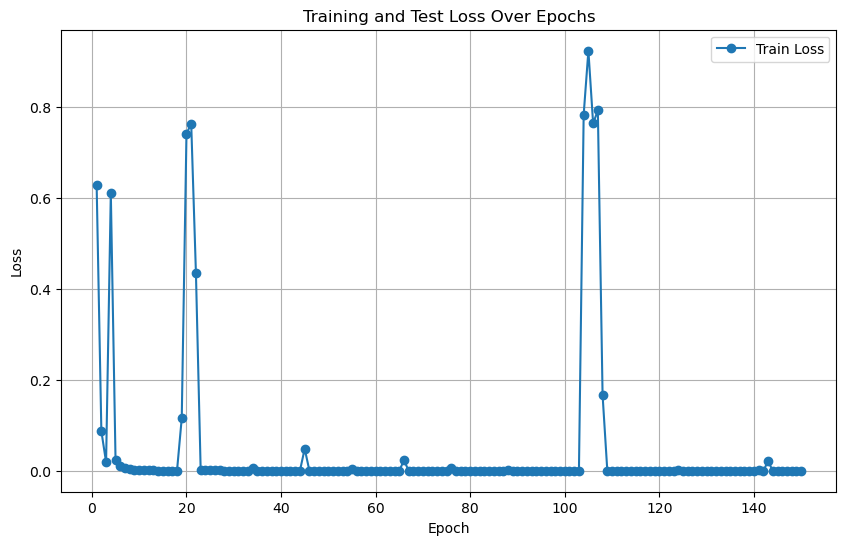

In [126]:
plot_loss(data_frame['Loss_D'], 'discriminator')


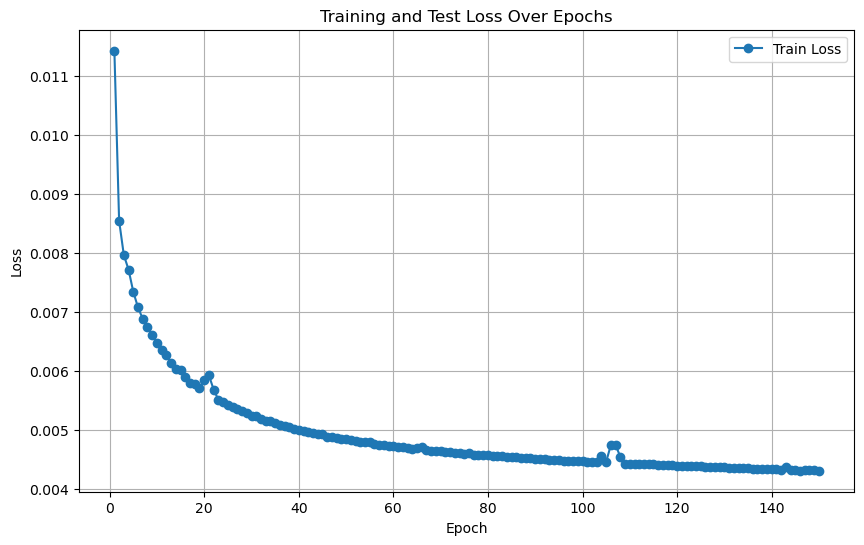

In [127]:
plot_loss(data_frame['Loss_G'], 'generator')

In [118]:
data_frame

,Loss_D,Loss_G,Score_D,Score_G,PSNR
1,0.629884,0.011426,0.685475,0.318691,24.788773
2,0.087192,0.008547,0.958464,0.046223,24.807351
3,0.018746,0.007965,0.991076,0.010221,25.102318
4,0.611292,0.007719,0.552926,0.194305,25.441290
5,0.022896,0.007342,0.988797,0.011800,25.554746
...,...,...,...,...,...
146,0.000008,0.004317,0.999996,0.000004,26.701215
147,0.000008,0.004326,0.999996,0.000003,26.693753
148,0.000005,0.004318,0.999998,0.000003,26.683477
149,0.000004,0.004320,0.999998,0.000002,26.688138


In [74]:
torch.save(netG.state_dict(), 'srgan.pth')

In [96]:
def generate_dataset(netG, test_loader):
    netG.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    out_path = 'training_results/fake_data' + '/'
    l_r_path = 'training_results/low_res_data' + '/'
    h_r_path = 'training_results/high_res_data' + '/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    if not os.path.exists(l_r_path):
        os.makedirs(l_r_path)
    if not os.path.exists(h_r_path):
        os.makedirs(h_r_path)
    count = 0
    with torch.no_grad():
        for val_lr, val_hr, labels in tqdm(test_loader):
            if count >= 1000:
                break
            batch_size = val_lr.size(0)
            lr = val_lr
            if device == 'cuda':
                lr = lr.float().cuda()
            fake_img = netG(lr)
            for i in range(batch_size):
                label = labels[i].item()
                str_label = 'cat' if label == 0 else 'dog'
                utils.save_image(fake_img[i], out_path + str(count)  + '_' + str_label + '.png')
                utils.save_image(lr[i], l_r_path + str(count) + '_' + str_label + '.png')
                utils.save_image(val_hr[i], h_r_path + str(count) + '_' + str_label + '.png')
                count += 1


In [97]:
generate_dataset(netG, train_loader)

  6%|▌         | 32/547 [00:33<08:57,  1.04s/it]


In [98]:
# Example usage: Replace 'training_results/fake_data' and 'fake_data.zip' with your desired paths
zip_folder('training_results/fake_data', 'training_results/fake_data.zip')

Folder 'training_results/fake_data' successfully zipped to 'training_results/fake_data.zip'
